### Data Loading

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
import pickle

In [2]:
# Load the dataset
file_path = 'blinkit_data.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataset
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
# Get basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


### Data Cleaning & Preprocessing

In [4]:
# Check for missing values
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [5]:
# Handle missing values
# Group the data by 'Item_Identifier' and calculate the mean weight for each group
item_mean_weight = df.groupby('Item_Identifier')['Item_Weight'].transform('mean')

# Fill the missing values in 'Item_Weight' with the corresponding mean weight of the item category
df['Item_Weight'].fillna(item_mean_weight, inplace=True)

#Replacing with mode
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)

In [25]:
# Verify that there are no more missing values in 'Item_Weight'
df.isnull().sum()

,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_MRP,0
Outlet_Establishment_Year,0
...,...
Item_Identifier_NCZ30,0
Item_Identifier_NCZ41,0
Item_Identifier_NCZ42,0
Item_Identifier_NCZ53,0


In [24]:
#Removing the rows that still have null values
df = df.dropna()

In [8]:
#Checking for duplicates
import pandas as pd

df.duplicated().sum()

0

In [9]:
# Standardize the 'Item_Fat_Content' values
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

# Verify the unique values to ensure the mapping worked correctly
print(df['Item_Fat_Content'].value_counts())


Item_Fat_Content
Low Fat    5516
Regular    3003
Name: count, dtype: int64


### EDA - Exploratory Data Analysis

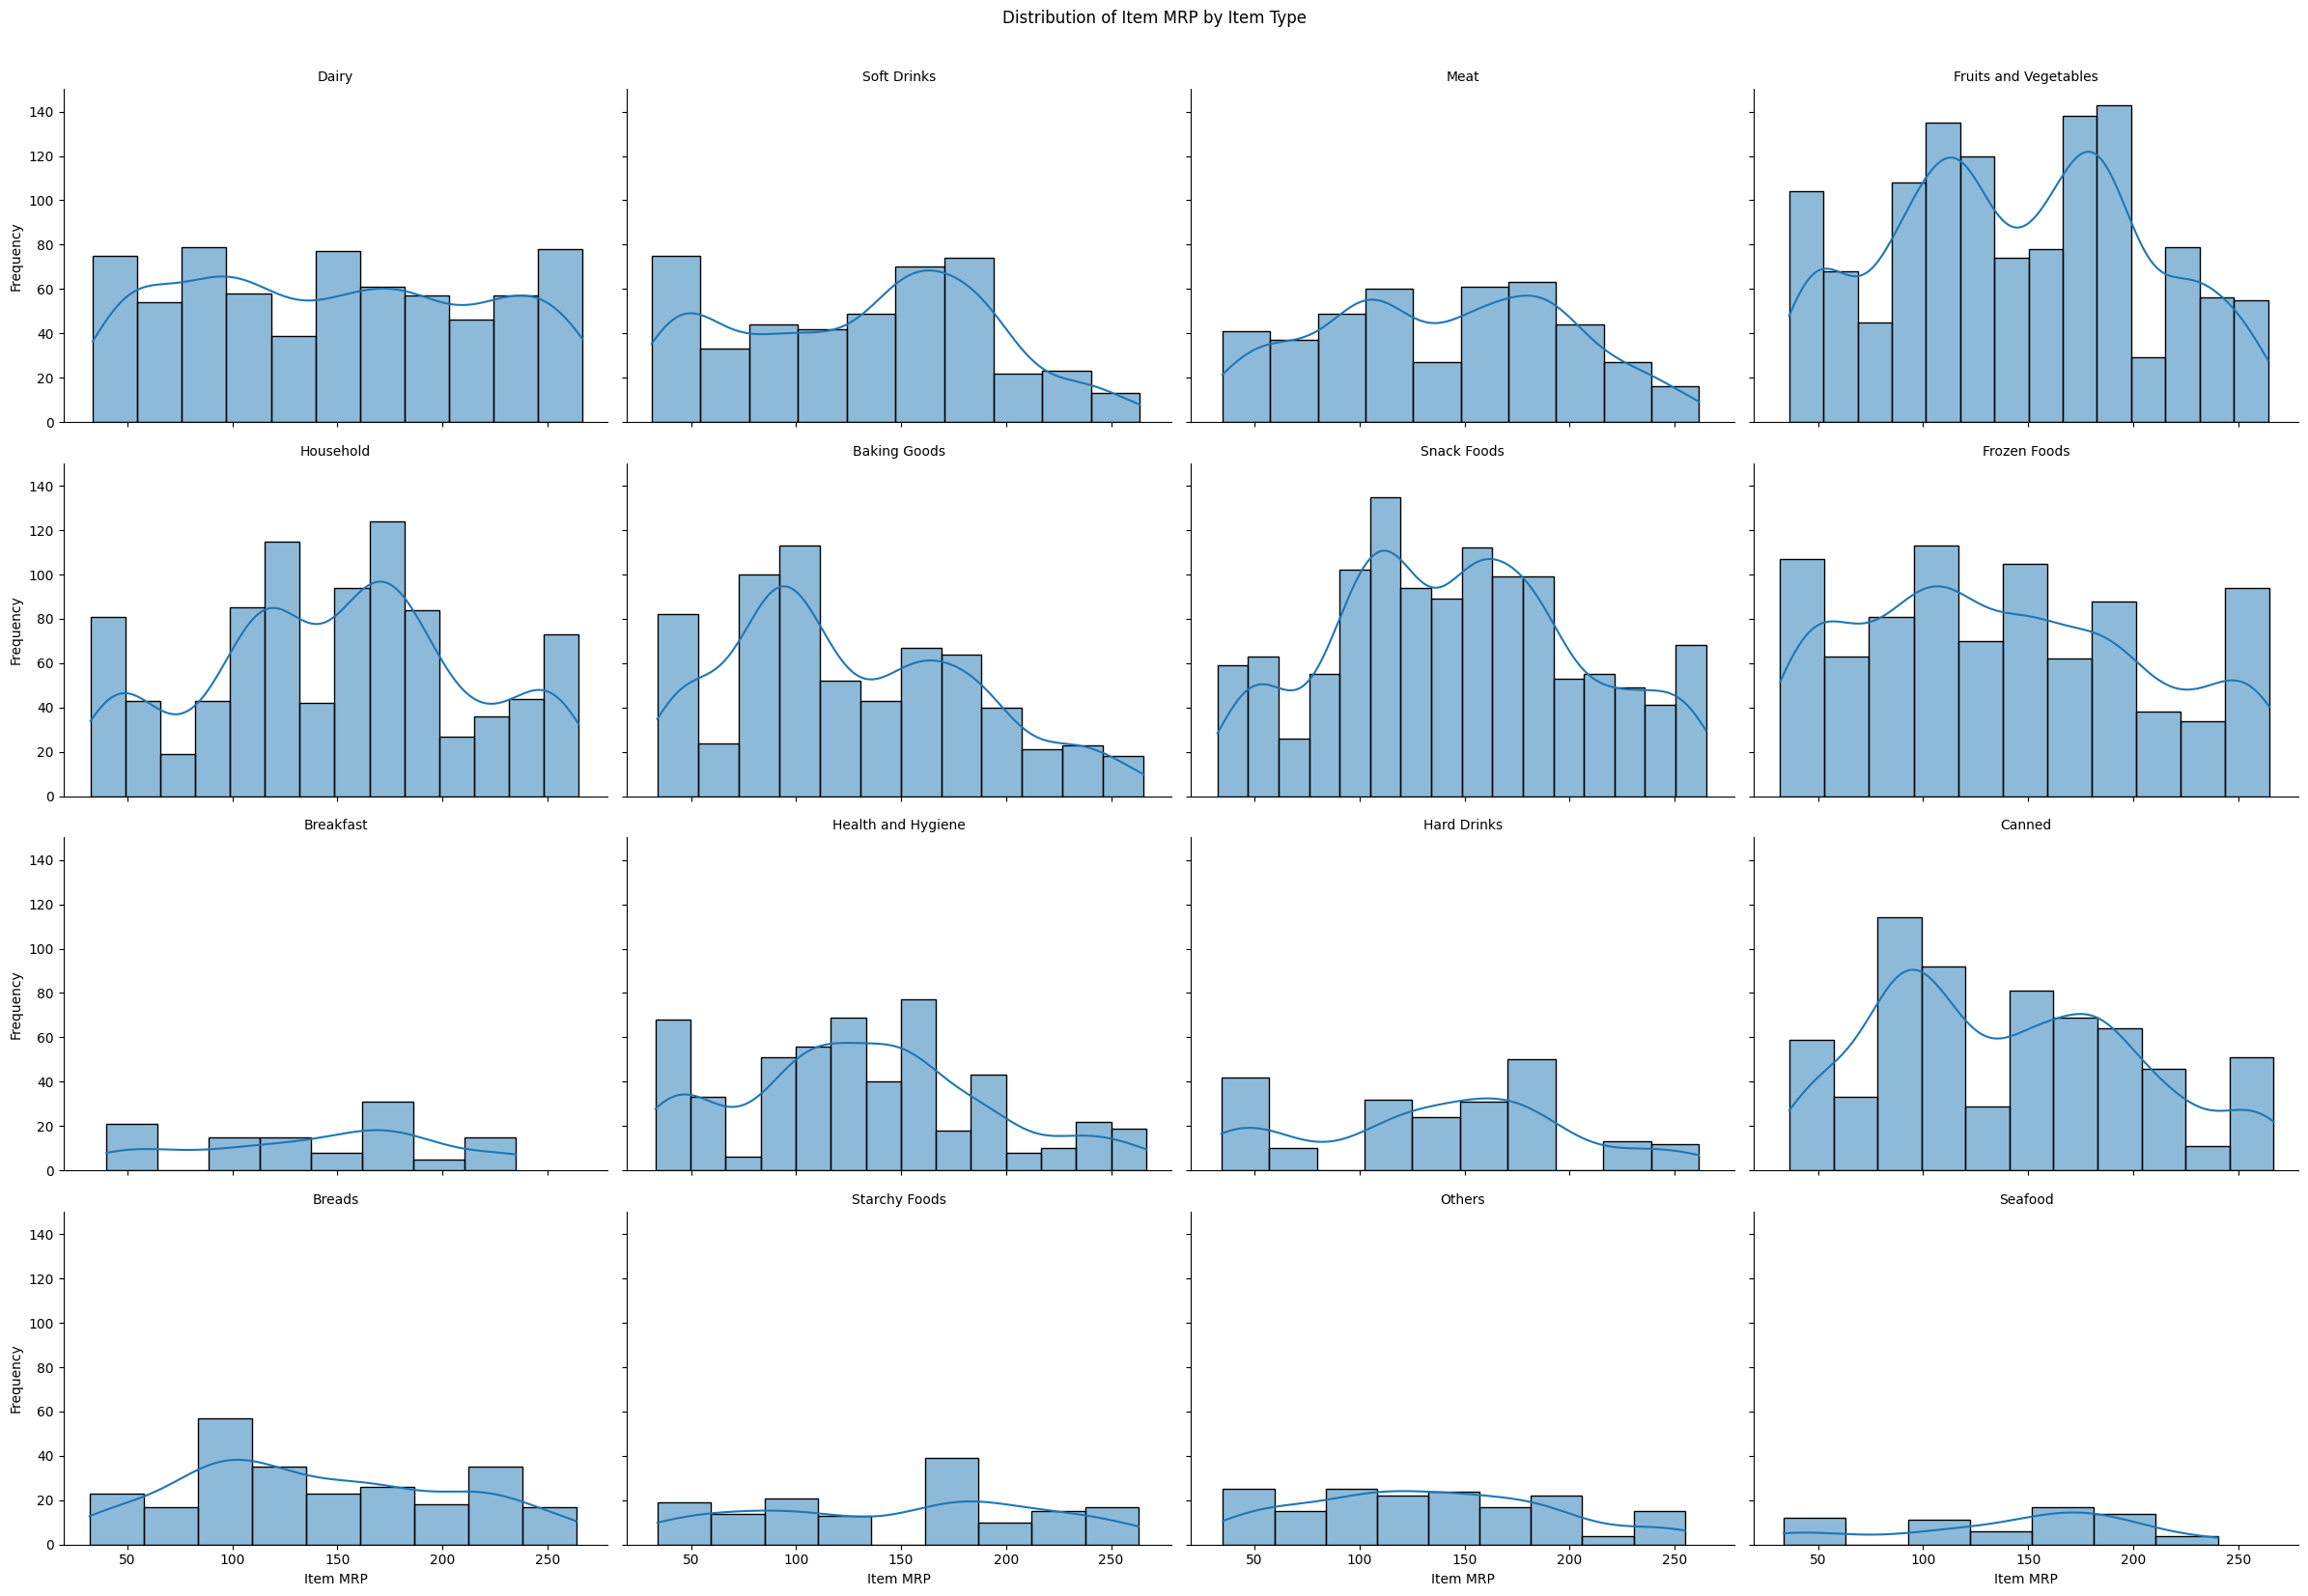

In [10]:
# Distribution of Item MRP
g = sns.FacetGrid(df, col='Item_Type', col_wrap=4, height=4, aspect=1.5, palette='Set2')
g.map(sns.histplot, 'Item_MRP', kde=True)
g.set_titles('{col_name}')
g.set_axis_labels('Item MRP', 'Frequency')
g.fig.suptitle('Distribution of Item MRP by Item Type', y=1.03)
plt.show()


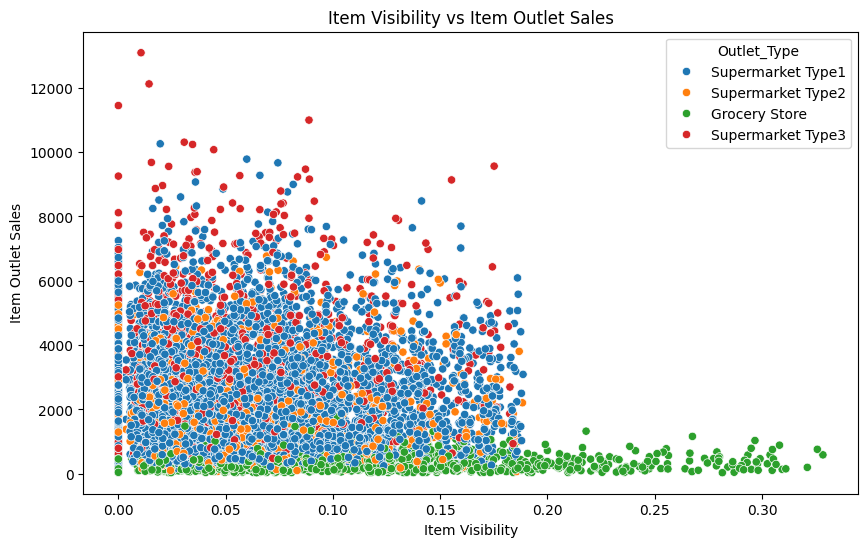

In [11]:
# Item Visibility vs Item Outlet Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', hue='Outlet_Type', data=df)
plt.title('Item Visibility vs Item Outlet Sales')
plt.xlabel('Item Visibility')
plt.ylabel('Item Outlet Sales')
plt.show()

<ipython-input-12-8451ff542737>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df, jitter=True, palette='Pastel1')


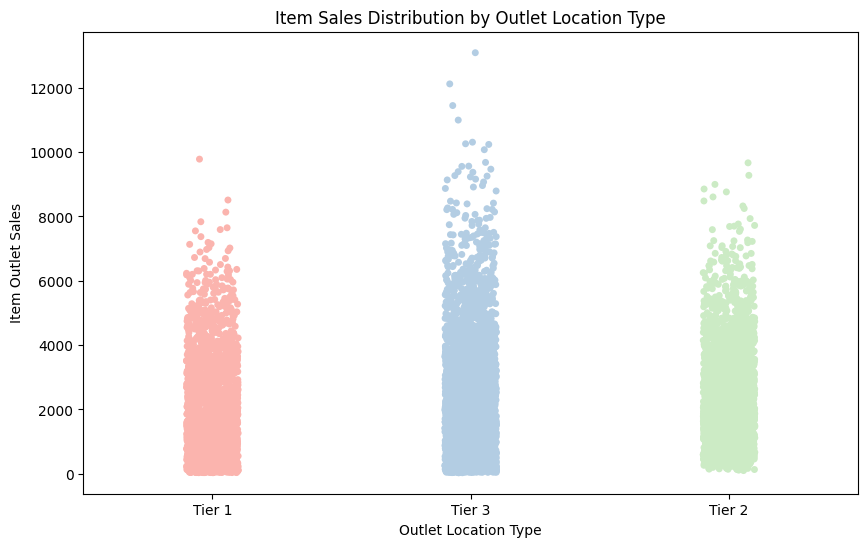

In [12]:
# Item Sales Distribution by Outlet Location Type
plt.figure(figsize=(10, 6))
sns.stripplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df, jitter=True, palette='Pastel1')
plt.title('Item Sales Distribution by Outlet Location Type')
plt.xlabel('Outlet Location Type')
plt.ylabel('Item Outlet Sales')
plt.show()


<ipython-input-13-d4593419b776>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data=df, errorbar=None, palette=colors)
<ipython-input-13-d4593419b776>:9: UserWarning: 
The palette list has fewer values (6) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data=df, errorbar=None, palette=colors)


Text(0.5, 1.0, 'Item Type vs. Item Outlet Sales')

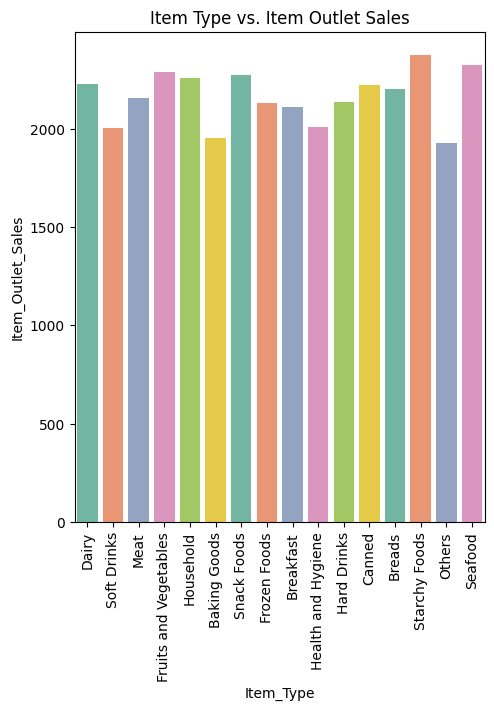

In [13]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 14))

# Custom color palette
colors = sns.color_palette('Set2', n_colors=6)

# Plot 1: Item Type vs. Item Outlet Sales
plt.subplot(2, 3, 1)
sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data=df, errorbar=None, palette=colors)
plt.xticks(rotation=90)
plt.title('Item Type vs. Item Outlet Sales')

<ipython-input-14-e75c67af2958>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Item_Type', y='Item_MRP', data=df, palette='Set2')


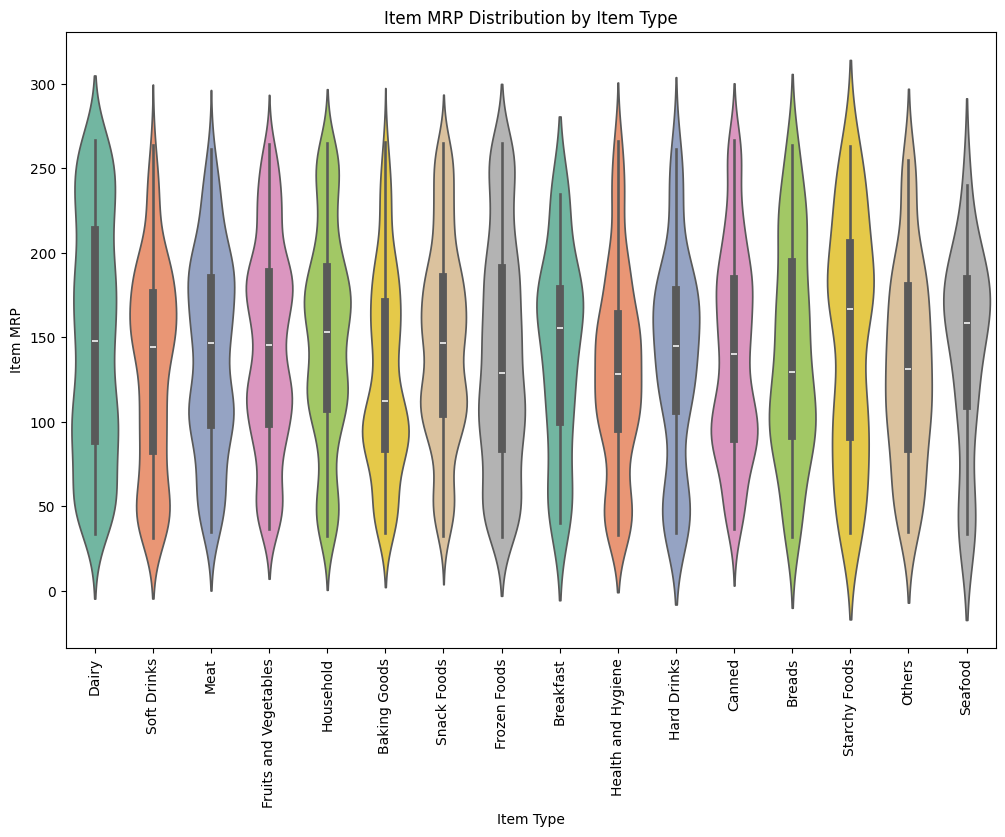

In [14]:
# Item MRP Distribution by Item Type
plt.figure(figsize=(12, 8))
sns.violinplot(x='Item_Type', y='Item_MRP', data=df, palette='Set2')
plt.xticks(rotation=90)
plt.title('Item MRP Distribution by Item Type')
plt.xlabel('Item Type')
plt.ylabel('Item MRP')
plt.show()


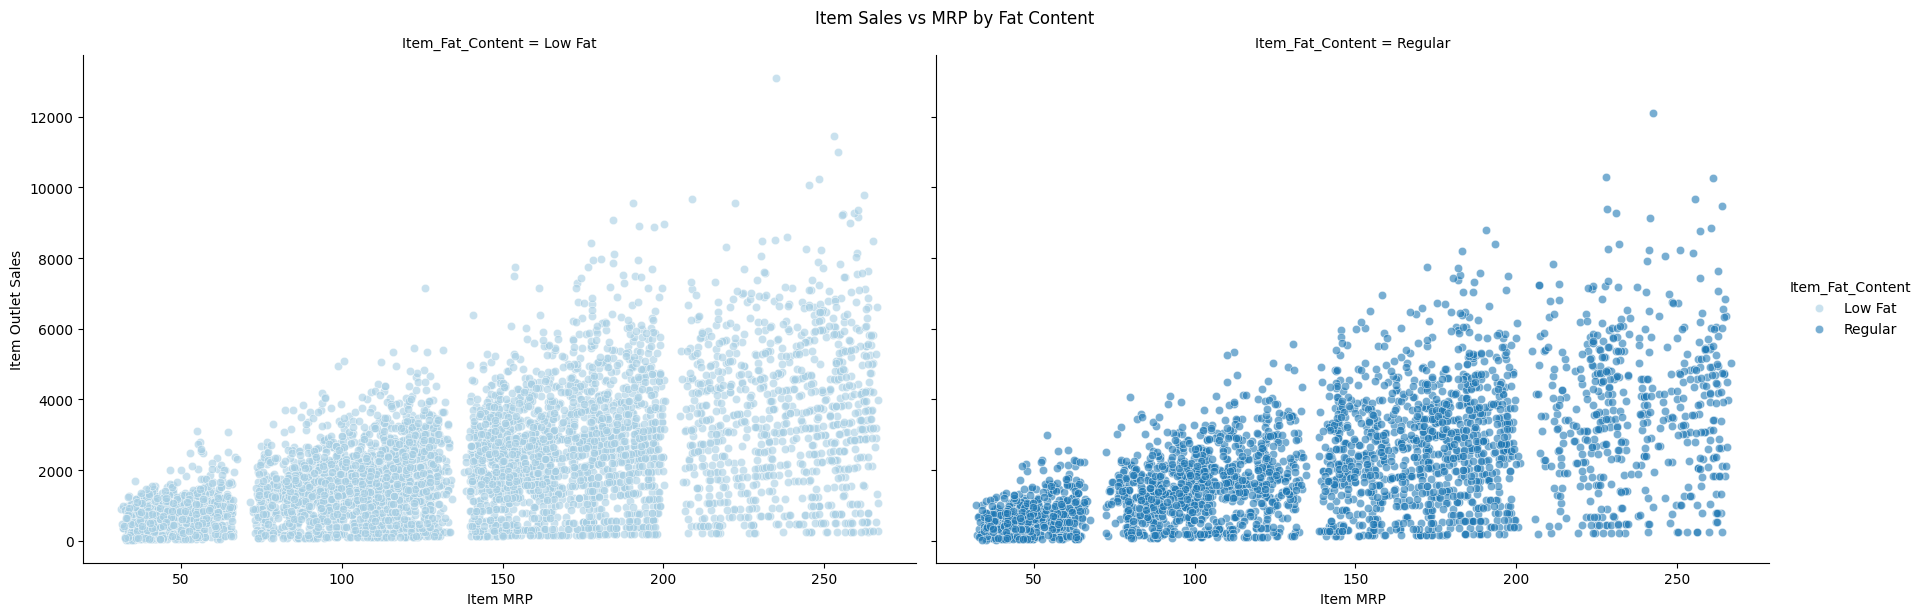

In [15]:
# Item Sales vs. MRP by Fat Content
g = sns.FacetGrid(df, col='Item_Fat_Content', hue='Item_Fat_Content', height=6, aspect=1.5, palette='Paired')
g.map(sns.scatterplot, 'Item_MRP', 'Item_Outlet_Sales', alpha=0.6)
g.add_legend()
g.set_axis_labels('Item MRP', 'Item Outlet Sales')
g.fig.suptitle('Item Sales vs MRP by Fat Content', y=1.02)
plt.show()



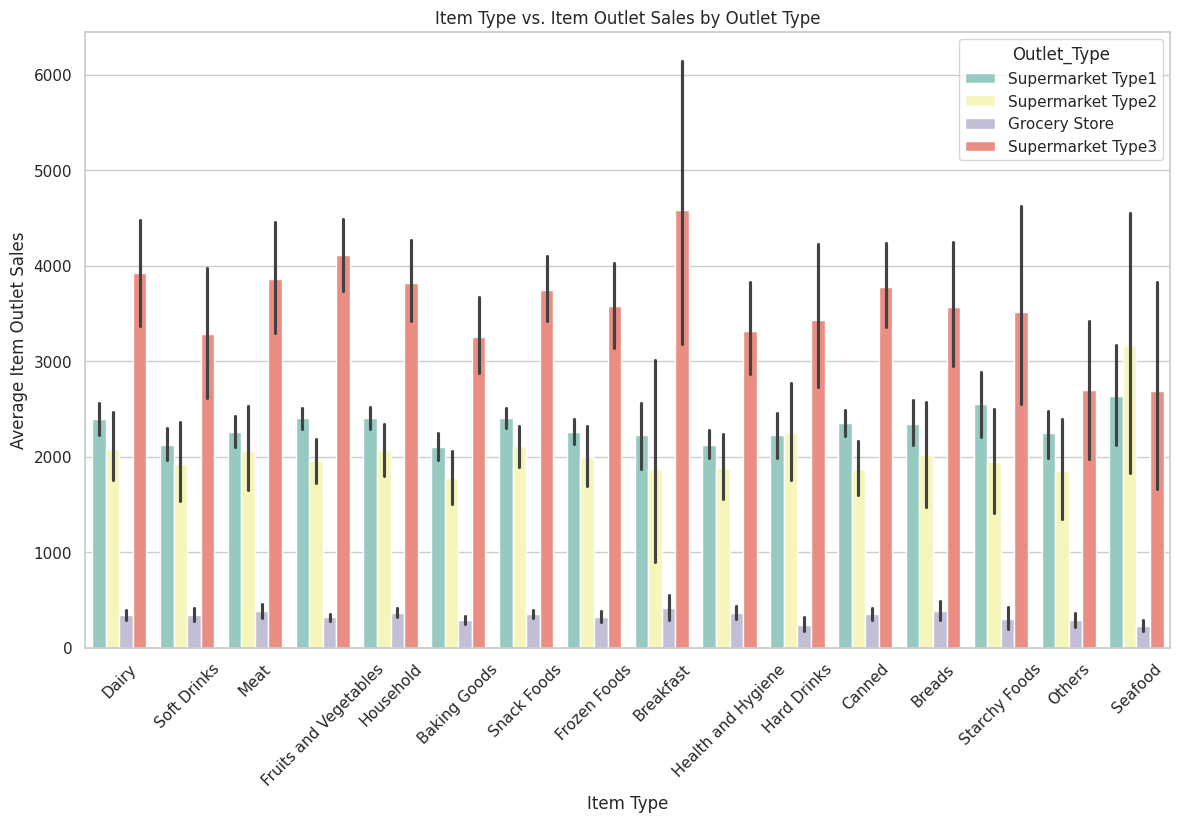

In [16]:
# Set the style for the plots
sns.set(style='whitegrid')

# Item Type vs. Sales with Outlet Type as hue
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='Item_Type', y='Item_Outlet_Sales', hue='Outlet_Type', palette='Set3')
plt.title('Item Type vs. Item Outlet Sales by Outlet Type')
plt.xlabel('Item Type')
plt.ylabel('Average Item Outlet Sales')
plt.xticks(rotation=45)
plt.show()


### Feature Engineering

In [17]:
# Get the current year
current_year = datetime.datetime.now().year

# Calculate Outlet_Age
df['Outlet_Age'] = current_year - df['Outlet_Establishment_Year']

# Display the first few rows to check the new feature
print(df[['Outlet_Establishment_Year', 'Outlet_Age']].head())


   Outlet_Establishment_Year  Outlet_Age
0                       1999          25
1                       2009          15
2                       1999          25
3                       1998          26
4                       1987          37


In [18]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,25
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,15
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,25
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,26
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,37


In [19]:
# Initialize LabelEncoder
le = LabelEncoder()

# Apply Label Encoding to binary categorical feature 'Item_Fat_Content'
df['Item_Fat_Content'] = le.fit_transform(df['Item_Fat_Content']).astype(int)


In [20]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,25
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,15
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,25
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,26
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,37


In [21]:
# Initialize OneHotEncoder with drop='first' to avoid multicollinearity
ohe = OneHotEncoder(sparse=False, drop='first')

# List of columns to apply One-Hot Encoding
columns_to_encode = ['Item_Type', 'Outlet_Identifier', 'Outlet_Size',
                     'Outlet_Location_Type', 'Outlet_Type','Item_Identifier']

# Apply One-Hot Encoding
encoded_features = ohe.fit_transform(df[columns_to_encode])

# Convert encoded features to a DataFrame and ensure integer values
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(columns_to_encode)).astype(int)

# Concatenate the original dataframe with the encoded dataframe
df = pd.concat([df.drop(columns_to_encode, axis=1), encoded_df], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
# Display the first few rows to check the new features
df.head(15)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Identifier_NCZ05,Item_Identifier_NCZ06,Item_Identifier_NCZ17,Item_Identifier_NCZ18,Item_Identifier_NCZ29,Item_Identifier_NCZ30,Item_Identifier_NCZ41,Item_Identifier_NCZ42,Item_Identifier_NCZ53,Item_Identifier_NCZ54
0,9.300,0.0,0.016047,249.8092,1999.0,3735.1380,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.920,1.0,0.019278,48.2692,2009.0,443.4228,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.500,0.0,0.016760,141.6180,1999.0,2097.2700,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19.200,1.0,0.000000,182.0950,1998.0,732.3800,26.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.930,0.0,0.000000,53.8614,1987.0,994.7052,37.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,10.395,1.0,0.000000,51.4008,2009.0,556.6088,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,13.650,1.0,0.012741,57.6588,1987.0,343.5528,37.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,19.000,0.0,0.127470,107.7622,1985.0,4022.7636,39.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,16.200,1.0,0.016687,96.9726,2002.0,1076.5986,22.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,19.200,1.0,0.094450,187.8214,2007.0,4710.5350,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelling and predictions

In [36]:
# Select features that start with 'Item', excluding 'Item_Fat_Content'
features = [col for col in df.columns if col.startswith('Item') and col != 'Item_Fat_Content']
X = df[features]

# Define the target variable
y = df['Item_Fat_Content']


In [37]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
#New Code
# Define the models to be compared
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

In [39]:
#New Code
# Initialize variables to store the best model and its accuracy
best_model = None
best_accuracy = 0

# Iterate over each model, fit, and evaluate it
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

Logistic Regression Accuracy: 0.6605989430416911
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.80      1125
         1.0       0.00      0.00      0.00       578

    accuracy                           0.66      1703
   macro avg       0.33      0.50      0.40      1703
weighted avg       0.44      0.66      0.53      1703

[[1125    0]
 [ 578    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Accuracy: 0.6975924838520259
              precision    recall  f1-score   support

         0.0       0.69      0.97      0.81      1125
         1.0       0.74      0.17      0.28       578

    accuracy                           0.70      1703
   macro avg       0.72      0.57      0.54      1703
weighted avg       0.71      0.70      0.63      1703

[[1090   35]
 [ 480   98]]
XGBClassifier Accuracy: 0.8150322959483265
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1125
         1.0       0.83      0.57      0.68       578

    accuracy                           0.82      1703
   macro avg       0.82      0.76      0.77      1703
weighted avg       0.82      0.82      0.80      1703

[[1059   66]
 [ 249  329]]
SVC Accuracy: 0.6605989430416911
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.80      1125
         1.0       0.00      0.00      0.00       578

    accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# Output the best model and its accuracy
print(f"\nBest Model: {best_model.__class__.__name__} with Accuracy: {best_accuracy}")
print(f"\n{best_model.__class__.__name__} classification report:\n {classification_report(y_test, y_pred)}")


Best Model: XGBClassifier with Accuracy: 0.8150322959483265

XGBClassifier classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1125
         1.0       0.83      0.57      0.68       578

    accuracy                           0.82      1703
   macro avg       0.82      0.76      0.77      1703
weighted avg       0.82      0.82      0.80      1703



In [41]:
# Make predictions with the best model
y_pred = best_model.predict(X_test)

In [42]:
# Generate confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred)

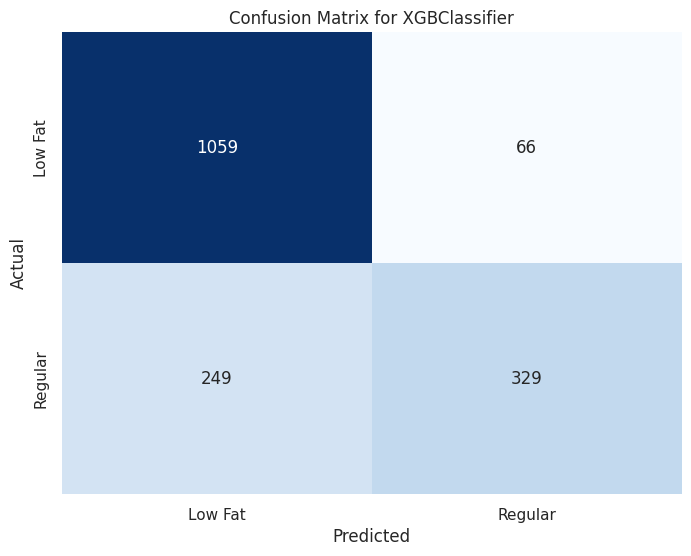

In [43]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Low Fat', 'Regular'], yticklabels=['Low Fat', 'Regular'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model.__class__.__name__}')
plt.show()

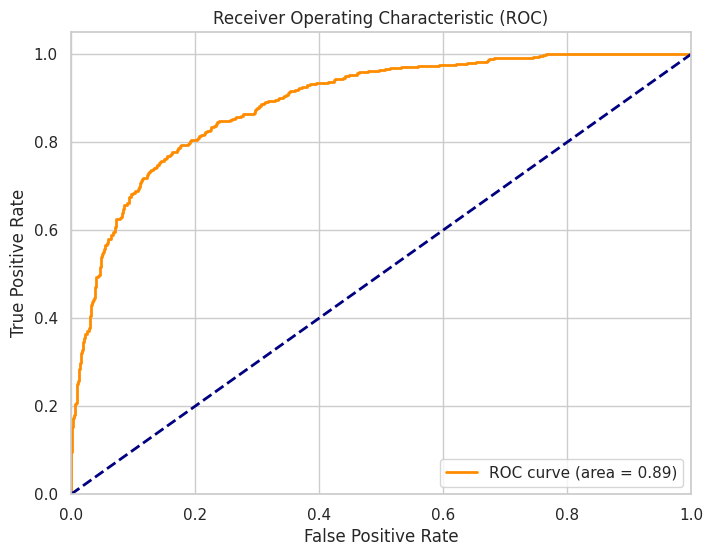

In [44]:
# Calculate probabilities for ROC curve
y_probs = best_model.predict_proba(X_test)[:, 1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Saving model for deployment using Streamlit

In [48]:
# Save the best model to disk
filename = f'{best_model.__class__.__name__}_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

In [49]:
# Save the list of columns
model_columns = X.columns.tolist()
with open('model_columns.pkl', 'wb') as file:
    pickle.dump(model_columns, file)